# note-0-just-test
This notebook is for just testing the inference of a model.
It loads the full-trained model for demonstration and test it on the MNIST dataset.

## Flow
1. Install the dependencies
1. Preset the environment
1. Load the model
1. Test the model

## Step

### 1. Install the dependencies

In [1]:
!pip install --quiet --upgrade pip
!pip install --quiet -r requirements.txt

# Preset

In [2]:
import os, requests
import matplotlib.pyplot as plt
import torch, torchvision

# Config
## env
FORCE_CPU = True
SAMPLE_MODEL_URL = "https://github.com/jyje/pilot-mlops-cicd/raw/refs/heads/develop/assets/sample_model.pt"

## logic
CHANNEL_SIZE = 3
RESIZE_SIZE = (224, 224)

NORMALIZE_MEAN = (0.5,0.5,0.5)
NORMALIZE_STD = (0.5,0.5,0.5)

DATA_ROOT_PATH = "./data"
MODEL_ROOT_PATH = "./models"
MODEL_NAME = "pilot"
MODEL_VERSION = "1"

# Hyperparameters
learning_rate = 0.001
momentum = 0.9
num_epochs = 3
batch_size = 100
num_workers = 0 # main process
t_max = 200

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(RESIZE_SIZE),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: x.repeat(CHANNEL_SIZE, 1, 1)),
        torchvision.transforms.Normalize(NORMALIZE_MEAN,NORMALIZE_STD),
    ]
)

if FORCE_CPU:
    device = torch.device("cpu")
    print("CPU is forced. Using CPU.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. torch.cuda is the API for NVIDIA GPU support")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("MPS is available and built. torch.mps is the API for Apple Silicon GPU.")
else:
    device = torch.device("cpu")
    print("Neither CUDA nor MPS is available or built. Using CPU.")

CPU is forced. Using CPU.


# Get Dataset

In [3]:
dataset_test = torchvision.datasets.MNIST(root=DATA_ROOT_PATH, train=False, download=True, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

## Load Model

In [4]:
if os.path.exists(f"{MODEL_ROOT_PATH}/{MODEL_NAME}/{MODEL_VERSION}/model.pt"):
    print("The model already exists. Loading the model...")
else:
    print("The model not found. Downloading the model...")
    os.makedirs(f"{MODEL_ROOT_PATH}/{MODEL_NAME}/{MODEL_VERSION}", exist_ok=True)

    response = requests.get(SAMPLE_MODEL_URL)
    with open(f"{MODEL_ROOT_PATH}/{MODEL_NAME}/{MODEL_VERSION}/model.pt", "wb") as f:
        f.write(response.content)

loaded_model = torch.jit.load(f"{MODEL_ROOT_PATH}/{MODEL_NAME}/{MODEL_VERSION}/model.pt")

loaded_model.eval()
loaded_model = loaded_model.to(device)

The model already exists. Loading the model...


## Test Model

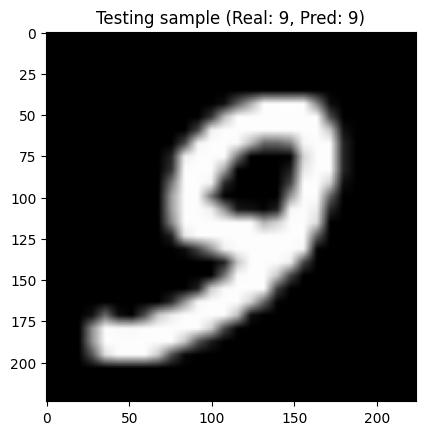

Predicted Label: 9
Real Label: 9
Probability Distribution:
 - Number 0: 4.02%
 - Number 1: 0.14%
 - Number 2: 0.78%
 - Number 3: 1.94%
 - Number 4: 0.32%
 - Number 5: 1.61%
 - Number 6: 0.28%
 - Number 7: 0.16%
 - Number 8: 2.09%
 - Number 9: 88.67%


In [5]:
sample_images, sample_labels = next(iter(dataloader_test))

image_data = sample_images[0].unsqueeze(0).to(device)
response = loaded_model(image_data)
probabilities = torch.nn.functional.softmax(response, dim=1)
predicted_class = torch.argmax(probabilities).item()

image_display = sample_images[0].permute(1, 2, 0) # (C, H, W) -> (H, W, C)
image_display = (image_display + 1) / 2 # Normalize Grayscale to [0, 1]
plt.imshow(image_display)
plt.title(f"Testing sample (Real: {sample_labels[0]}, Pred: {predicted_class})")
plt.show()

print(f"Predicted Label: {predicted_class}")
print(f"Real Label: {sample_labels[0].item()}")
print(f"Probability Distribution:")
for idx, prob in enumerate(probabilities[0]):
    print(f" - Number {idx}: {prob.item()*100:.2f}%")